# Pronóstico de voto según el CIS

En este cuaderno estudiamos el macrosondeo electoral del CIS previo a las elecciones de noviembre de 2019. Esencialmente, entrenaremos un modelo a partir de aquellos encuestados que declararon un intención de voto explícitamente, y, con ello, interamos estimar el de aquellos que no lo declararon.

Una vez tengamos la estimación, agregaremos los datos para dar una estimación de lo que podría haber estimado el CIS. Por comodidad, y ya que se trata de un ejercicio teórico, nos centramos en una única provinvia, Málaga.

El CIS del que hablamos sobrevaloró al PSOE y Cs en 3-4 puntos, e infravaloró al PP y a Vox en 3 y 7 puntos, respectivamente. Veremos que la estimación que hacemos para Málaga siguió la misma línea.

Comenzamos cargando las librerias necesarias, así como los microdatos del sondeo, que el CIS las suministra en formato spss.

## Preprocesado

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install pyreadstat

You should consider upgrading via the 'c:\users\evaes\anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
import pyreadstat

In [5]:
#la primera vez...
!pip install boto3 

You should consider upgrading via the 'c:\users\evaes\anaconda3\python.exe -m pip install --upgrade pip' command.


In [6]:
import boto3

BUCKET_NAME = 'electomedia' 

# sustituir por credenciales de acceso. 
s3 = boto3.resource('s3', aws_access_key_id = 'xxxxxxxxxx', 
                          aws_secret_access_key= 'xxxxxxxxxxxxxxx')

In [7]:
import botocore.exceptions

KEY = 'EstimacionOtrasFuentes/CIS_N19.sav' 

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'CIS_N19.sav')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
    print("The object does not exist.")
    else:
    raise

In [8]:
cis = pd.read_spss('CIS_N19.sav')

In [9]:
cis.head()

,ESTU,CUES,CCAA,PROV,MUN,TAMUNI,CAPITAL,DISTR,SECCION,ENTREV,...,VOTOSIMG,P9BR,P13R,P14R,P15R,P17AR,RECUERDO,ESTUDIOS,PESO,PESOCCAA
0,3263.0,1.0,País Vasco,Araba/Álava,Burgos / Vitoria-Gasteiz,100.001 a 400.000 habitantes,Capital de CC.AA.,Anonimizado,Anonimizado,Anonimizado,...,PSOE,NaN,PSOE,N.S.,PSOE,PSOE,PSOE,Secundaria 1ª etapa,0.52587,0.5208
1,3263.0,2.0,País Vasco,Araba/Álava,Burgos / Vitoria-Gasteiz,100.001 a 400.000 habitantes,Capital de CC.AA.,Anonimizado,Anonimizado,Anonimizado,...,No sabe todavía,NaN,EH Bildu,PSOE,Unidas Podemos,EH Bildu,EH Bildu,Superiores,0.52587,0.5208
2,3263.0,3.0,País Vasco,Araba/Álava,Burgos / Vitoria-Gasteiz,100.001 a 400.000 habitantes,Capital de CC.AA.,Anonimizado,Anonimizado,Anonimizado,...,PP,No votaría,PP,PSOE,N.C.,NaN,No votó,Primaria,0.52587,0.5208
3,3263.0,4.0,País Vasco,Araba/Álava,Burgos / Vitoria-Gasteiz,100.001 a 400.000 habitantes,Capital de CC.AA.,Anonimizado,Anonimizado,Anonimizado,...,En blanco,NaN,Ninguno,N.S.,N.S.,N.C.,N.C.,Superiores,0.52587,0.5208
4,3263.0,5.0,País Vasco,Araba/Álava,Burgos / Vitoria-Gasteiz,100.001 a 400.000 habitantes,Capital de CC.AA.,Anonimizado,Anonimizado,Anonimizado,...,N.C.,NaN,Unidas Podemos,PSOE,EH Bildu,N.C.,N.C.,Superiores,0.52587,0.5208


Vemos que tenemos 146 filas; sin duda, no todas serán imprescindibles. El número de encuestas fue de algo más de 17 mil.

In [10]:
cis.shape

(17650, 146)

In [11]:
cols = cis.columns

In [12]:
cols

Index(['ESTU', 'CUES', 'CCAA', 'PROV', 'MUN', 'TAMUNI', 'CAPITAL', 'DISTR',
       'SECCION', 'ENTREV',
       ...
       'VOTOSIMG', 'P9BR', 'P13R', 'P14R', 'P15R', 'P17AR', 'RECUERDO',
       'ESTUDIOS', 'PESO', 'PESOCCAA'],
      dtype='object', length=146)

Como hemos indicado, nos centraremos en la provincia de Málaga.

In [13]:
cis_malaga = cis.loc[cis['PROV'] == 'Málaga']

In [14]:
cis_malaga

,ESTU,CUES,CCAA,PROV,MUN,TAMUNI,CAPITAL,DISTR,SECCION,ENTREV,...,VOTOSIMG,P9BR,P13R,P14R,P15R,P17AR,RECUERDO,ESTUDIOS,PESO,PESOCCAA
9768,3263.0,9980.0,Andalucía,Málaga,Donostia/San Sebastián / Marbella,100.001 a 400.000 habitantes,Otros municipios,Anonimizado,Anonimizado,Anonimizado,...,Unidas Podemos,Unidas Podemos,IU,PSOE,Unidas Podemos,Unidas Podemos,Unidas Podemos,Secundaria 2ª etapa,1.19808,1.129
9769,3263.0,9981.0,Andalucía,Málaga,Donostia/San Sebastián / Marbella,100.001 a 400.000 habitantes,Otros municipios,Anonimizado,Anonimizado,Anonimizado,...,PSOE,N.S.,PSOE,PSOE,PSOE,PSOE,PSOE,Sin estudios,1.19808,1.129
9770,3263.0,9982.0,Andalucía,Málaga,Donostia/San Sebastián / Marbella,100.001 a 400.000 habitantes,Otros municipios,Anonimizado,Anonimizado,Anonimizado,...,PSOE,PP,PSOE,PSOE,PSOE,PSOE,PSOE,Secundaria 1ª etapa,1.19808,1.129
9771,3263.0,9983.0,Andalucía,Málaga,Donostia/San Sebastián / Marbella,100.001 a 400.000 habitantes,Otros municipios,Anonimizado,Anonimizado,Anonimizado,...,VOX,PSOE,PSOE,PSOE,VOX,PSOE,PSOE,F.P.,1.19808,1.129
9772,3263.0,9984.0,Andalucía,Málaga,Donostia/San Sebastián / Marbella,100.001 a 400.000 habitantes,Otros municipios,Anonimizado,Anonimizado,Anonimizado,...,PSOE,No votaría,PSOE,PSOE,PSOE,PSOE,PSOE,Secundaria 1ª etapa,1.19808,1.129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10246,3263.0,10458.0,Andalucía,Málaga,Málaga,400.001 a 1.000.000 habitantes,Capital de provincia,Anonimizado,Anonimizado,Anonimizado,...,PP,VOX,PP,PSOE,PP,VOX,VOX,Secundaria 1ª etapa,1.19808,1.129
10247,3263.0,10459.0,Andalucía,Málaga,Málaga,400.001 a 1.000.000 habitantes,Capital de provincia,Anonimizado,Anonimizado,Anonimizado,...,PSOE,En blanco,PSOE,PSOE,PSOE,PSOE,PSOE,Secundaria 1ª etapa,1.19808,1.129
10248,3263.0,10460.0,Andalucía,Málaga,Málaga,400.001 a 1.000.000 habitantes,Capital de provincia,Anonimizado,Anonimizado,Anonimizado,...,No votaría,NaN,Ciudadanos,PSOE,Ciudadanos,Ciudadanos,C's,Primaria,1.19808,1.129
10249,3263.0,10461.0,Andalucía,Málaga,Málaga,400.001 a 1.000.000 habitantes,Capital de provincia,Anonimizado,Anonimizado,Anonimizado,...,En blanco,NaN,Ninguno,PSOE,Ninguno,En blanco,En blanco,Superiores,1.19808,1.129


El CIS nombra las columnas mediante una serie de códigos alfanuméricos. Iremos desgranando su significado a lo largo del cuaderno.

In [15]:
cis_malaga['MUN'].value_counts()

Mun.<=100.000 hab. no capitales de CA o provincia    259
Málaga                                               187
Donostia/San Sebastián / Marbella                     37
Ávila / Barcelona                                      0
Cáceres                                                0
                                                    ... 
Mérida                                                 0
Mataró                                                 0
Lugo                                                   0
Lleida / Palencia                                      0
Albacete                                               0
Name: MUN, Length: 64, dtype: int64

La columna P9 es la varable objetivo, representa la intención de voto de los encuestados, que vemos que prefieren al PSOE.

In [16]:
cis_malaga['P9'].value_counts()

PSOE                                       130
No votará                                   68
No lo tiene decidido aún                    58
PP                                          55
Ciudadanos                                  37
VOX                                         34
Unidas Podemos                              33
N.C.                                        25
Voto blanco                                 16
N.S.                                        12
IU                                           7
Más País                                     3
Voto nulo                                    3
PACMA                                        1
Podemos                                      1
PRC (Partido Regionalista de Cantabria)      0
Falange Española de las JONS                 0
BNG (Bloque Nacionalista Galego)             0
CC-PNC                                       0
CUP                                          0
UPyD                                         0
Coalición por

In [17]:
cis_malaga['P9'].value_counts().sum()

483

La variable P17A representa el recuerdo del voto en las elecciones de abril de 19, las anteriores.

In [18]:
cis_malaga['P17A'].value_counts().sum()

403

In [19]:
cis_malaga['P17A'].value_counts()

PSOE                                       161
PP                                          65
Ciudadanos                                  56
Unidas Podemos                              50
VOX                                         31
N.C.                                        18
En blanco                                   12
No recuerda                                  5
Otros partidos                               3
Voto nulo                                    2
EH Bildu                                     0
CC-PNC                                       0
Compromís                                    0
EAJ-PNV                                      0
JxCat                                        0
ERC                                          0
En Comú Podem                                0
PRC (Partido Regionalista de Cantabria)      0
UPN (Navarra Suma)                           0
BNG (Bloque Nacionalista Galego)             0
Name: P17A, dtype: int64

La P13 es otra columna importante, la de qué partido es más cercano a las ideas del encuestado.

In [20]:
cis_malaga['P13'].value_counts()

PSOE                                       154
Ninguno                                     93
PP                                          65
Ciudadanos                                  49
Unidas Podemos                              39
VOX                                         32
IU                                          21
N.C.                                        12
N.S.                                        12
PACMA                                        2
Más País                                     2
Podemos                                      2
PRC (Partido Regionalista de Cantabria)      0
FAC (Foro Asturias)                          0
BNG (Bloque Nacionalista Galego)             0
CC-PNC                                       0
CUP                                          0
UPyD                                         0
Coalición por Melilla                        0
Compromís                                    0
EAJ-PNV                                      0
EH Bildu     

Ahora pasasmo a la codificación de los partidos. Nos apoyamos en el hecho que todos guardan una relación ideológica que se puede representar, por ejemplo, como yendo de 0 a 100 según pensemos que tal partido está a la izquierda o derecha. Para otras respuestas tomamos el valor medio, 50.

In [21]:
cod_partidos = {'Unidas Podemos' : 0,
                'Podemos' : 0,
                'IU' : 5, 
                'Más País' : 15,
                'PSOE' : 30,
                'Ciudadanos' : 60,
                'Ninguno' : 50,
                'N.C.' : 50,
                'N.S.' : 50,
                'PP' : 65,
                'VOX' : 100,
                'Otro' : 50}

En el caso de la columna P9 nos adaptamos a las respuestas dadas. Paradójicamente, una serie de encuestados contestó IU, que no se presentaba. Ajustaremos este resultado al final del cuaderno cuando estimemos el resultado de las elecciones en Málaga.

In [22]:
cod_partidos_P9 = {'Unidas Podemos' : 0,
                'Podemos' : 0,
                'IU' : 5, 
                'Más País' : 15,
                'PSOE' : 30,
                'Ciudadanos' : 60,
                'No votará' : 50,
                'PP' : 70,
                'VOX' : 100}

Otra seríe de columanas importantes son las probabilidades de votar a tal o cual partido.

In [23]:
cis_malaga['P1201'].value_counts()

0 Con toda seguridad, no lo votaría nunca    224
10 Con toda seguridad, lo votaría siempre     71
5.0                                           42
8.0                                           30
4.0                                           24
2.0                                           17
7.0                                           16
9.0                                           14
6.0                                           13
3.0                                           13
1.0                                           13
N.C.                                           4
N.S.                                           2
Name: P1201, dtype: int64

In [24]:
cis_malaga['P1201'].unique()

[0 Con toda seguridad, no lo votaría nunca, 10 Con toda seguridad, lo votaría siempre, 9, 5, 3, ..., 7, 2, N.C., 1, N.S.]
Length: 13
Categories (13, object): [0 Con toda seguridad, no lo votaría nunca, 10 Con toda seguridad, lo votaría siempre, 9, 5, ..., 2, N.C., 1, N.S.]

In [25]:
cis_malaga['P1201'].astype('object').unique()

array(['0 Con toda seguridad, no lo votaría nunca',
       '10 Con toda seguridad, lo votaría siempre', 9.0, 5.0, 3.0, 8.0,
       4.0, 6.0, 7.0, 2.0, 'N.C.', 1.0, 'N.S.'], dtype=object)

Para este tipo de columnas lo que hacemos es preparar un diccionario para mapear las columnas, sustituyendo las filas con 0 o 10 por su valor numérico. Para el resto de respuestas respetamos el valor dado.

In [26]:
cod_probs = {'0 Con toda seguridad, no lo votaría nunca' : 0,
             1 : 1,
             2 : 2,
             3 : 3,
             4 : 4,
             5 : 5,
             6 : 6,
             7 : 7,
             8 : 8,
             9 : 9,
             '10 Con toda seguridad, lo votaría siempre' : 10,
             'N.C.' : 3,
             'N.S.' : 3}

In [27]:
cis_malaga['P1201'].astype('object').value_counts()

0 Con toda seguridad, no lo votaría nunca    224
10 Con toda seguridad, lo votaría siempre     71
5.0                                           42
8.0                                           30
4.0                                           24
2.0                                           17
7.0                                           16
9.0                                           14
6.0                                           13
3.0                                           13
1.0                                           13
N.C.                                           4
N.S.                                           2
Name: P1201, dtype: int64

In [28]:
cis_malaga['P1001'].astype('object').unique()

array([4.0, 7.0, 5.0, 8.0, 6.0, '1 Muy mal', '10 Muy bien', 3.0, 2.0,
       'N.S.', 'N.C.', 9.0], dtype=object)

Algo parecido ocurre con las columnas de los políticos nacionales, en escala de 1 a 10 en esta ocasión. Preparamos también un mapeo.

In [29]:
cod_valoracion =  {'1 Muy mal' : 1,
              2 : 2,
              3 : 3,
              4 : 4,
              5 : 5,
              6 : 6,
              7 : 7,
              8 : 8,
              9 : 9,
             '10 Muy bien' : 10,
             'N.C.' : 3,
             'N.S.' : 3}

La columna P9A es el partido por el que se siente mayor simpatía, lo cual es importante.

In [30]:
cis_malaga['P9A'].value_counts()

Ninguno                                    130
PSOE                                        13
Ciudadanos                                   9
PP                                           7
N.S.                                         7
N.C.                                         6
IU                                           3
Podemos                                      3
Unidas Podemos                               2
PACMA                                        1
VOX                                          1
Compromís                                    0
EAJ-PNV                                      0
EH Bildu                                     0
En blanco                                    0
EQUO                                         0
ERC                                          0
CUP                                          0
CC-PNC                                       0
En Comú Podem                                0
En Marea                                     0
Más País     

Vemos que la mayor parte de las columnas son de tipo category. Nos convendrá pasarla a objeto antes de mapear.

In [31]:
cis_malaga.dtypes

ESTU         float64
CUES         float64
CCAA        category
PROV        category
MUN         category
              ...   
P17AR       category
RECUERDO    category
ESTUDIOS    category
PESO         float64
PESOCCAA     float64
Length: 146, dtype: object

Debemos escoger aquellas columnas que nos parecen más importantes. Se trata de aquellas que, como hemos visto, tienen que ver con valoraciones políticas, recuerdo de voto, interés por la política, ubicación ideológica, así como unos breves datos del encuestado como son su edad, nivel de estudios, etc..

Otras preguntas como qué emisora de radio suele escuchar nos han parecido, al menos en principio, prescindibles.

In [32]:
list_cols = ['TAMUNI', 'CAPITAL', 'P1', 'P2', 'P3', 'P4', 'P601', 'P701', 'P8', 'P8A', 'P8B01', 'P8B02', 'P9', 'P9A', 'P1001', 'P1002', 'P1003', 'P1004', 'P1005', 'P1006',
             'P11', 'P1201', 'P1202', 'P1203', 'P1204', 'P1205', 'P1206', 'P13', 'P14', 'P15', 'P17A', 'P18', 'P1901', 'P1902', 'P1903', 'P1904', 'P1905', 'P1906', 'P23', 'P24', 'P25',
             'P25A', 'P26', 'P27']

Nos quedamos pues con 44 columnas.

In [33]:
len(list_cols)

44

In [34]:
cis_malaga = cis_malaga[list_cols]

In [35]:
cis_malaga

,TAMUNI,CAPITAL,P1,P2,P3,P4,P601,P701,P8,P8A,...,P1903,P1904,P1905,P1906,P23,P24,P25,P25A,P26,P27
9768,100.001 a 400.000 habitantes,Otros municipios,Bastante,Habitualmente,Muy mala,Regular,La corrupción y el fraude,Los problemas relacionados con la calidad del ...,"Sí, con toda seguridad","Sí, lo tiene decidido",...,8,1 Izquierda,1 Izquierda,10 Derecha,Mujer,24,"Sí, ha ido a la escuela","Bachillerato/COU/PREU (Bachillerato Superior, ...",Trabaja,Ateo/a
9769,100.001 a 400.000 habitantes,Otros municipios,Bastante,De vez en cuando,Mala,Regular,"Los/as políticos/as en general, los partidos y...",La sanidad,"Sí, con toda seguridad","Sí, lo tiene decidido",...,7,2,1 Izquierda,10 Derecha,Hombre,84,"No, pero sabe leer y escribir",NaN,Jubilado/a o pensionista (anteriormente ha tra...,Católico/a no practicante
9770,100.001 a 400.000 habitantes,Otros municipios,Nada,Nunca o casi nunca,Muy mala,Mala,La corrupción y el fraude,El paro,"Sí, con toda seguridad","No, no lo ha decidido aún",...,5,1 Izquierda,1 Izquierda,10 Derecha,Mujer,45,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Parado/a y ha trabajado antes,Católico/a no practicante
9771,100.001 a 400.000 habitantes,Otros municipios,Poco,De vez en cuando,Mala,Mala,El paro,Ninguno,"Sí, con toda seguridad","Sí, lo tiene decidido",...,5,2,2,7,Hombre,34,"Sí, ha ido a la escuela",Formación Profesional de Grado Superior (FP II),Trabaja,Católico/a no practicante
9772,100.001 a 400.000 habitantes,Otros municipios,Poco,De vez en cuando,Muy mala,Mala,La educación,El paro,"Sí, con toda seguridad","Sí, lo tiene decidido",...,6,3,2,9,Mujer,48,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Parado/a y ha trabajado antes,Católico/a no practicante
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10246,400.001 a 1.000.000 habitantes,Capital de provincia,Poco,De vez en cuando,Mala,Regular,La falta de acuerdos. Situación política. Ines...,Los problemas de índole económica,"Sí, con toda seguridad","Sí, lo tiene decidido",...,7,2,3,8,Hombre,34,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Trabaja,Católico/a no practicante
10247,400.001 a 1.000.000 habitantes,Capital de provincia,Nada,Rara vez,Mala,Regular,La corrupción y el fraude,El paro,"Sí, con toda seguridad","Sí, lo tiene decidido",...,7,2,2,10 Derecha,Mujer,41,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Parado/a y ha trabajado antes,Católico/a no practicante
10248,400.001 a 1.000.000 habitantes,Capital de provincia,Nada,De vez en cuando,Muy mala,Muy mala,Independencia de Cataluña,Los problemas relacionados con la calidad del ...,"Sí, con toda seguridad","No, no lo ha decidido aún",...,6,3,4,9,Mujer,57,"Sí, ha ido a la escuela",Primaria (enseñanza primaria o hasta 5º de EGB),Trabaja,Católico/a no practicante
10249,400.001 a 1.000.000 habitantes,Capital de provincia,Bastante,De vez en cuando,Muy mala,Muy mala,"Los/as políticos/as en general, los partidos y...",El paro,"Sí, con toda seguridad","Sí, lo tiene decidido",...,7,1 Izquierda,3,8,Hombre,40,"Sí, ha ido a la escuela","Universitarios superiores (licenciatura, grado...",Trabaja,Católico/a no practicante


Todas las columnas son de tipo category, por el momento, antes de proceder a los mapeos.

In [36]:
cis_malaga.dtypes

TAMUNI     category
CAPITAL    category
P1         category
P2         category
P3         category
P4         category
P601       category
P701       category
P8         category
P8A        category
P8B01      category
P8B02      category
P9         category
P9A        category
P1001      category
P1002      category
P1003      category
P1004      category
P1005      category
P1006      category
P11        category
P1201      category
P1202      category
P1203      category
P1204      category
P1205      category
P1206      category
P13        category
P14        category
P15        category
P17A       category
P18        category
P1901      category
P1902      category
P1903      category
P1904      category
P1905      category
P1906      category
P23        category
P24        category
P25        category
P25A       category
P26        category
P27        category
dtype: object

Hacemos un repaso de las columas elegidas. Vemos que las P8B01 y 02, sobre los partidos entre los que se duda, tienen pocos datos, por lo que las eliminaremos.

In [37]:
cols_partidos = ['P8B01', 'P8B02', 'P9A', 'P13', 'P14', 'P15', 'P17A']

In [38]:
cis_malaga['P8B02'].value_counts().sum()

103

In [39]:
cis_malaga['P8B01'].value_counts().sum()

103

In [40]:
cis_malaga['P9'].value_counts().sum()

483

In [41]:
cis_malaga['P9A'].value_counts().sum()

182

In [42]:
cis_malaga['P17A'].value_counts().sum()

403

In [43]:
cols_partidos_aj = ['P9A', 'P13', 'P14', 'P15', 'P17A']

In [44]:
cis_malaga = cis_malaga.drop(['P8B01', 'P8B02'], axis = 1)

In [45]:
cis_malaga.shape

(483, 42)

Repasamos de nuevo la columna P9, la intención directa de voto.

In [46]:
cis_malaga['P9'].value_counts().sum()

483

In [47]:
cis_malaga['P9'].value_counts()

PSOE                                       130
No votará                                   68
No lo tiene decidido aún                    58
PP                                          55
Ciudadanos                                  37
VOX                                         34
Unidas Podemos                              33
N.C.                                        25
Voto blanco                                 16
N.S.                                        12
IU                                           7
Más País                                     3
Voto nulo                                    3
PACMA                                        1
Podemos                                      1
PRC (Partido Regionalista de Cantabria)      0
Falange Española de las JONS                 0
BNG (Bloque Nacionalista Galego)             0
CC-PNC                                       0
CUP                                          0
UPyD                                         0
Coalición por

Llevamos a cabo el primer mapeo, el de la columna P9. 

Creemos que este tipo de mapeos, que tienen solo en cuenta la columna afectada y no ninguan otra, no afectan a la división posterior entre train y test.

In [48]:
cis_malaga['P9'] = cis_malaga['P9'].astype('object').map(cod_partidos_P9)

Mapeamos los códigos de los partidos con el diccionario antes descrito.

In [49]:
for col in cols_partidos_aj:

  cis_malaga[col] = cis_malaga[col].astype('object').map(cod_partidos)

In [50]:
cis_malaga['P9'].value_counts().sum()

368

In [51]:
cis_malaga['P9'].value_counts()

30.0     130
50.0      68
70.0      55
60.0      37
0.0       34
100.0     34
5.0        7
15.0       3
Name: P9, dtype: int64

Vemos el resultado de los mapeos en la P13, partido más cercano a las ideas del encuestado.

In [52]:
cis_malaga['P13'].value_counts().sum()

481

In [53]:
cis_malaga['P13'].value_counts()

30.0     154
50.0     117
65.0      65
60.0      49
0.0       41
100.0     32
5.0       21
15.0       2
Name: P13, dtype: int64

In [54]:
cis_malaga.dtypes

TAMUNI     category
CAPITAL    category
P1         category
P2         category
P3         category
P4         category
P601       category
P701       category
P8         category
P8A        category
P9          float64
P9A         float64
P1001      category
P1002      category
P1003      category
P1004      category
P1005      category
P1006      category
P11        category
P1201      category
P1202      category
P1203      category
P1204      category
P1205      category
P1206      category
P13         float64
P14           int64
P15         float64
P17A        float64
P18        category
P1901      category
P1902      category
P1903      category
P1904      category
P1905      category
P1906      category
P23        category
P24        category
P25        category
P25A       category
P26        category
P27        category
dtype: object

Vemos, en nuestra opinión, que será más sencillo pasar los yipos category a objeto antes de hacer los mapeos.

In [55]:
cis_malaga['P1001'].value_counts()

1 Muy mal      127
5.0             79
4.0             60
7.0             52
6.0             42
3.0             41
8.0             30
2.0             25
10 Muy bien     14
9.0             10
N.C.             2
N.S.             1
No conoce        0
Name: P1001, dtype: int64

In [56]:
cis_malaga['P1001'].astype('object').value_counts()

1 Muy mal      127
5.0             79
4.0             60
7.0             52
6.0             42
3.0             41
8.0             30
2.0             25
10 Muy bien     14
9.0             10
N.C.             2
N.S.             1
Name: P1001, dtype: int64

In [57]:
cis_malaga['P1201'].value_counts()

0 Con toda seguridad, no lo votaría nunca    224
10 Con toda seguridad, lo votaría siempre     71
5.0                                           42
8.0                                           30
4.0                                           24
2.0                                           17
7.0                                           16
9.0                                           14
6.0                                           13
3.0                                           13
1.0                                           13
N.C.                                           4
N.S.                                           2
Name: P1201, dtype: int64

Agrupamos las columnas para los que aplicaremos mapeos: aquellos con valoraciones de políticos, y aquellas con probabilidades de voto a partidos.

In [58]:
cols_valoración = ['P1001', 'P1002', 'P1003', 'P1004', 'P1005', 'P1006']

In [59]:
cols_prob = ['P1201', 'P1202', 'P1203', 'P1204', 'P1205', 'P1206']

Ahora tenemos que ver las columnas 190x, que son aquellas de ubicación ideológica de cada uno de los partidos a ojos del encuestado. Preparamos un diccionario para su mapeo también.

In [60]:
cis_malaga['P1901'].astype('object').value_counts()

4.0            183
3.0            136
5.0             66
2.0             34
1 Izquierda     30
N.S.            22
N.C.             8
6.0              4
Name: P1901, dtype: int64

In [61]:
cis_malaga['P1901'].astype('object').unique()

array([5.0, 3.0, 4.0, 2.0, 'N.C.', 'N.S.', 6.0, '1 Izquierda'],
      dtype=object)

In [62]:
cod_ubicación =  {'1 Izquierda' : 1,
              2 : 2,
              3 : 3,
              4 : 4,
              5 : 5,
              6 : 6,
              7 : 7,
              8 : 8,
              9 : 9,
             '10 Derecha' : 10,
             'N.C.' : 5,
             'N.S.' : 5}

In [63]:
cis_malaga['P1901'].astype('object').map(cod_ubicación).value_counts()

4    183
3    136
5     96
2     34
1     30
6      4
Name: P1901, dtype: int64

Repasamos que las columnas 190x tienen los mismos elementos para evitar problemas, cosa que es el caso.

In [64]:
cis_malaga['P1902'].astype('object').unique()

array([9.0, 8.0, 6.0, 7.0, 'N.C.', 'N.S.', 5.0, '10 Derecha'],
      dtype=object)

In [65]:
cis_malaga['P1903'].astype('object').unique()

array([8.0, 7.0, 5.0, 6.0, 'N.S.', 'N.C.', 4.0, '10 Derecha', 9.0],
      dtype=object)

In [66]:
cis_malaga['P1904'].astype('object').unique()

array(['1 Izquierda', 2.0, 3.0, 'N.S.', 'N.C.', 4.0], dtype=object)

In [67]:
cis_malaga['P1905'].astype('object').unique()

array(['1 Izquierda', 2.0, 'N.C.', 'N.S.', 8.0, 3.0, 4.0, 5.0],
      dtype=object)

In [68]:
cis_malaga['P1906'].astype('object').unique()

array(['10 Derecha', 7.0, 9.0, 8.0, 'N.C.', 'N.S.', 6.0, 4.0,
       '1 Izquierda'], dtype=object)

Agrupamos en otra lista las columnas de ubicación.

In [69]:
cols_ubicación = ['P1901', 'P1902', 'P1903', 'P1904', 'P1905', 'P1906']

Continuamos pues con los mapeos, en este caso los de valoraciones.

In [70]:
for col in cols_valoración:

  cis_malaga[col] = cis_malaga[col].astype('object').map(cod_valoracion, na_action='ignore')

In [71]:
cis_malaga['P1004'].value_counts()

1     239
3      59
2      48
4      44
5      33
6      30
7      14
8       8
10      6
9       2
Name: P1004, dtype: int64

Mapeos de probabilidades de voto a partidos:

In [72]:
for col in cols_prob:

  cis_malaga[col] = cis_malaga[col].astype('object').map(cod_probs, na_action='ignore')

In [73]:
cis_malaga['P1204'].value_counts()

0     355
1      30
5      14
4      13
2      13
10     12
8      12
6      11
3      11
9       6
7       6
Name: P1204, dtype: int64

Y finalmente mapeo de ubicaciones ideológicas de los partidos.

In [74]:
for col in cols_ubicación:

  cis_malaga[col] = cis_malaga[col].astype('object').map(cod_ubicación, na_action='ignore')

In [75]:
cis_malaga['P1904'].value_counts()

1    171
2    121
3    120
5     52
4     19
Name: P1904, dtype: int64

In [76]:
cis_malaga.dtypes

TAMUNI     category
CAPITAL    category
P1         category
P2         category
P3         category
P4         category
P601       category
P701       category
P8         category
P8A        category
P9          float64
P9A         float64
P1001         int64
P1002       float64
P1003         int64
P1004         int64
P1005       float64
P1006       float64
P11        category
P1201         int64
P1202         int64
P1203         int64
P1204         int64
P1205         int64
P1206         int64
P13         float64
P14           int64
P15         float64
P17A        float64
P18        category
P1901         int64
P1902         int64
P1903         int64
P1904         int64
P1905         int64
P1906         int64
P23        category
P24        category
P25        category
P25A       category
P26        category
P27        category
dtype: object

Quedan un par de columnas importantes por mapear. La primera es la P11, la de probabilidad de votar en las elecciones. La preparamos para mapear.

In [77]:
cis_malaga['P11'].value_counts()

10 Con toda seguridad, irá a votar      262
0 Con toda seguridad, no irá a votar     65
9.0                                      53
8.0                                      35
7.0                                      25
5.0                                      15
2.0                                       8
6.0                                       6
3.0                                       5
4.0                                       4
1.0                                       3
N.C.                                      2
N.S.                                      0
Name: P11, dtype: int64

In [78]:
cis_malaga['P11'].astype('object').unique()

array(['10 Con toda seguridad, irá a votar', 4.0, 7.0,
       '0 Con toda seguridad, no irá a votar', 2.0, 9.0, 3.0, 'N.C.', 8.0,
       5.0, 1.0, 6.0], dtype=object)

In [79]:
cod_prob_votar =  {'0 Con toda seguridad, no irá a votar' : 0, 
              1 : 1,
              2 : 2,
              3 : 3,
              4 : 4,
              5 : 5,
              6 : 6,
              7 : 7,
              8 : 8,
              9 : 9,
             '10 Con toda seguridad, irá a votar' : 10,
             'N.C.' : 5,
             'N.S.' : 5}

In [80]:
cis_malaga['P11'] = cis_malaga['P11'].astype('object').map(cod_prob_votar, na_action='ignore')

In [81]:
cis_malaga['P11'].value_counts()

10    262
0      65
9      53
8      35
7      25
5      17
2       8
6       6
3       5
4       4
1       3
Name: P11, dtype: int64

Otra columna importante es la autoubicación ideológica del encuestado, que la preparamos para mapear también.

In [82]:
cis_malaga['P18'].value_counts()

3.0            105
5.0            102
4.0             77
7.0             46
6.0             44
2.0             34
8.0             25
N.C.            17
N.S.            16
1 Izquierda      9
9.0              5
10 Derecha       3
Name: P18, dtype: int64

In [83]:
cis_malaga['P18'] = cis_malaga['P18'].astype('object').map(cod_ubicación, na_action='ignore')

In [84]:
cis_malaga['P18'].value_counts()

5     135
3     105
4      77
7      46
6      44
2      34
8      25
1       9
9       5
10      3
Name: P18, dtype: int64

Ya tenemos mapeados todas las columnas que hemos podido llevar a cabo antes de la separación train y test.

In [85]:
cis_malaga.dtypes

TAMUNI     category
CAPITAL    category
P1         category
P2         category
P3         category
P4         category
P601       category
P701       category
P8         category
P8A        category
P9          float64
P9A         float64
P1001         int64
P1002       float64
P1003         int64
P1004         int64
P1005       float64
P1006       float64
P11           int64
P1201         int64
P1202         int64
P1203         int64
P1204         int64
P1205         int64
P1206         int64
P13         float64
P14           int64
P15         float64
P17A        float64
P18           int64
P1901         int64
P1902         int64
P1903         int64
P1904         int64
P1905         int64
P1906         int64
P23        category
P24        category
P25        category
P25A       category
P26        category
P27        category
dtype: object

Hacemos un describe. Casi todas las columnas tienen rellenos sus registos, con pocos nan.

In [86]:
cis_malaga.describe()

,P9,P9A,P1001,P1002,P1003,P1004,P1005,P1006,P11,P1201,...,P14,P15,P17A,P18,P1901,P1902,P1903,P1904,P1905,P1906
count,368.000000,181.000000,483.000000,482.000000,483.000000,483.000000,446.000000,473.000000,483.000000,483.000000,...,483.000000,478.000000,381.00000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,45.788043,47.790055,4.202899,3.261411,3.465839,2.635611,3.020179,2.490486,7.708075,3.469979,...,35.817805,45.251046,43.08399,4.629400,3.606625,7.482402,6.024845,2.296066,2.412008,8.679089
std,26.566531,12.442316,2.583107,2.164283,2.268395,2.124676,2.305255,2.371354,3.541643,3.885369,...,11.820929,24.109719,26.60141,1.757416,1.096258,1.174240,1.046335,1.282392,1.306710,1.576052
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,1.000000,1.000000,5.000000,4.000000,1.000000,1.000000,1.000000
25%,30.000000,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,0.000000,...,30.000000,30.000000,30.00000,3.000000,3.000000,7.000000,5.000000,1.000000,1.000000,8.000000
50%,50.000000,50.000000,4.000000,3.000000,3.000000,2.000000,2.000000,1.000000,10.000000,2.000000,...,30.000000,50.000000,30.00000,5.000000,4.000000,8.000000,6.000000,2.000000,2.000000,9.000000
75%,60.000000,50.000000,6.000000,5.000000,5.000000,4.000000,5.000000,3.000000,10.000000,7.000000,...,30.000000,60.000000,65.00000,6.000000,4.000000,8.000000,7.000000,3.000000,3.000000,10.000000
max,100.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,100.000000,100.000000,100.00000,10.000000,6.000000,10.000000,10.000000,5.000000,8.000000,10.000000


Ahora viene un paso importante: nos quedamos para modelizar el voto con aquellos registros que declaran su voto, es decir, la columna no es nan.

Hay que recordar que explicitar que no se votará es un registro válido.

Para aquellos registros que no tengan declarado su voto, éste se estimará en producción, es decir, cuando tengamos el modelo entrenado y verificado con el test.

In [87]:
cis_malaga_modelo = cis_malaga[cis_malaga['P9'].notna()]

In [88]:
cis_malaga_modelo.shape

(368, 42)

##Set de Train

Llevamos a cabo el train test split, y como de costumbre nos quedamos solo con el train.

In [89]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cis_malaga_modelo, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('train_cis_malaga_modelo.txt', index=False)
test.to_csv('test_cis_malaga_modelo.txt', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

df_train = pd.read_csv('train_cis_malaga_modelo.txt')

Dimensiones del dataset de training: (294, 42)
Dimensiones del dataset de test: (74, 42)


In [90]:
df_train

,TAMUNI,CAPITAL,P1,P2,P3,P4,P601,P701,P8,P8A,...,P1903,P1904,P1905,P1906,P23,P24,P25,P25A,P26,P27
0,50.001 a 100.000 habitantes,Otros municipios,Poco,Rara vez,Mala,Mala,La corrupción y el fraude,Las pensiones,Probablemente sí,"Sí, lo tiene decidido",...,6,1,1,5,Mujer,72.0,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Jubilado/a o pensionista (anteriormente ha tra...,Católico/a no practicante
1,400.001 a 1.000.000 habitantes,Capital de provincia,Bastante,Habitualmente,Mala,Regular,El paro,El paro,"Sí, con toda seguridad","Sí, lo tiene decidido",...,6,3,4,9,Hombre,63.0,"Sí, ha ido a la escuela","Universitarios medios (diplomatura, Arquitectu...",Jubilado/a o pensionista (anteriormente ha tra...,Católico/a no practicante
2,10.001 a 50.000 habitantes,Otros municipios,Poco,De vez en cuando,Mala,Regular,El paro,Ninguno,Probablemente sí,"No, no lo ha decidido aún",...,5,5,5,5,Mujer,64.0,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Trabajo doméstico no remunerado,Católico/a no practicante
3,400.001 a 1.000.000 habitantes,Capital de provincia,Bastante,Habitualmente,Muy mala,Muy mala,El paro,El paro,"Sí, con toda seguridad","Sí, lo tiene decidido",...,4,2,3,9,Mujer,54.0,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Parado/a y ha trabajado antes,Católico/a no practicante
4,100.001 a 400.000 habitantes,Otros municipios,Bastante,De vez en cuando,Mala,Mala,El paro,N.S.,"Sí, con toda seguridad","Sí, lo tiene decidido",...,6,2,2,10,Hombre,48.0,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Trabaja,Católico/a no practicante
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,400.001 a 1.000.000 habitantes,Capital de provincia,Poco,Rara vez,Muy mala,Muy mala,El paro,Las pensiones,"Sí, con toda seguridad","Sí, lo tiene decidido",...,7,3,3,10,Mujer,75.0,"No, pero sabe leer y escribir",NaN,Trabajo doméstico no remunerado,Católico/a no practicante
290,50.001 a 100.000 habitantes,Otros municipios,Poco,De vez en cuando,Mala,Regular,El paro,Ninguno,"Sí, con toda seguridad","Sí, lo tiene decidido",...,6,3,3,8,Mujer,36.0,"Sí, ha ido a la escuela","Bachillerato/COU/PREU (Bachillerato Superior, ...",Trabaja,"Indiferente, no creyente"
291,400.001 a 1.000.000 habitantes,Capital de provincia,Bastante,De vez en cuando,Mala,Muy mala,Los problemas de índole económica,Los problemas relacionados con la calidad del ...,"Sí, con toda seguridad","Sí, lo tiene decidido",...,5,1,2,8,Hombre,50.0,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Trabaja,Ateo/a
292,2.001 a 10.000 habitantes,Otros municipios,Poco,De vez en cuando,Muy mala,Mala,La corrupción y el fraude,Los problemas de índole económica,"Sí, con toda seguridad","Sí, lo tiene decidido",...,6,2,2,10,Hombre,31.0,"Sí, ha ido a la escuela","Universitarios medios (diplomatura, Arquitectu...",Trabaja,"Indiferente, no creyente"


El primer paso que damos es el rellenar los nan en aquellas columnas que ya son numéricas. Lo hacemos tomando la media de la columna. Son pocos registros a los que se aplica, como hemos visto antes.

In [91]:
FillNA_num_mean = ['P9A', 'P13', 'P14', 'P15', 'P17A', 'P1201', 'P1202', 'P1203', 'P1204', 'P1205', 'P1206', 'P1001', 'P1002', 'P1003', 'P1004', 'P1005', 'P1006',
                   'P1901', 'P1902', 'P1903', 'P1904', 'P1905', 'P1906']

In [92]:
for item in FillNA_num_mean:
        
    df_train[item].fillna(df_train[item].mean(), inplace=True)

In [93]:
df_train.describe()

,P9,P9A,P1001,P1002,P1003,P1004,P1005,P1006,P11,P1201,...,P15,P17A,P18,P1901,P1902,P1903,P1904,P1905,P1906,P24
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,...,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,44.948980,48.584906,4.394558,3.248299,3.465986,2.571429,3.152416,2.569930,7.687075,3.697279,...,43.647260,41.898734,4.598639,3.588435,7.482993,6.044218,2.302721,2.360544,8.731293,49.462585
std,26.581335,5.774153,2.602330,2.183458,2.286001,2.103142,2.315367,2.496483,3.719339,4.191678,...,25.800539,25.671565,1.880962,1.079123,1.116759,1.058728,1.282672,1.292908,1.620867,17.322980
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,5.000000,4.000000,1.000000,1.000000,1.000000,18.000000
25%,30.000000,48.584906,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,0.000000,...,30.000000,30.000000,3.000000,3.000000,7.000000,5.000000,1.000000,1.000000,8.000000,35.250000
50%,50.000000,48.584906,4.000000,3.000000,3.000000,1.000000,3.000000,1.000000,10.000000,1.000000,...,43.647260,41.898734,4.000000,4.000000,8.000000,6.000000,2.000000,2.000000,9.000000,48.000000
75%,60.000000,48.584906,6.000000,5.000000,5.000000,4.000000,5.000000,4.000000,10.000000,8.000000,...,60.000000,60.000000,6.000000,4.000000,8.000000,7.000000,3.000000,3.000000,10.000000,63.000000
max,100.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,100.000000,100.000000,10.000000,6.000000,10.000000,10.000000,5.000000,8.000000,10.000000,88.000000


Llega la hora de hacer el mapeo con means, y este es donde desde luego hay que haber separado train y test. Tomamos por supuesto las variables categóricas. Guardamos el mapeo a llevar a cabo en el test. Preferimos aplicar un cambio de tipo a object.

In [94]:
categorical = ['TAMUNI', 'CAPITAL', 'P1', 'P2', 'P3', 'P4', 'P601', 'P701', 'P8', 'P8A', 'P23', 'P24', 'P25', 'P25A', 'P26', 'P27']

In [95]:
mean_map1 = {}
for c in categorical:
    
    # df_filtered[c].fillna(df_filtered[c].mode()[0], inplace=True)
    
    mean = df_train.groupby(c)['P9'].mean()
    df_train[c] = df_train[c].astype('object').map(mean)    
    mean_map1[c] = mean

Ya tenemos todas las columnas pasadas a valores numéricos.

In [96]:
df_train.dtypes

TAMUNI     float64
CAPITAL    float64
P1         float64
P2         float64
P3         float64
P4         float64
P601       float64
P701       float64
P8         float64
P8A        float64
P9         float64
P9A        float64
P1001        int64
P1002      float64
P1003        int64
P1004        int64
P1005      float64
P1006      float64
P11          int64
P1201        int64
P1202        int64
P1203        int64
P1204        int64
P1205        int64
P1206        int64
P13        float64
P14          int64
P15        float64
P17A       float64
P18          int64
P1901        int64
P1902        int64
P1903        int64
P1904        int64
P1905        int64
P1906        int64
P23        float64
P24        float64
P25        float64
P25A       float64
P26        float64
P27        float64
dtype: object

In [97]:
df_train.describe()

,TAMUNI,CAPITAL,P1,P2,P3,P4,P601,P701,P8,P8A,...,P1903,P1904,P1905,P1906,P23,P24,P25,P25A,P26,P27
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,237.000000,...,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,271.000000,294.000000,294.000000
mean,44.948980,44.948980,44.948980,44.948980,44.948980,44.948980,44.948980,44.948980,44.948980,44.071730,...,6.044218,2.302721,2.360544,8.731293,44.948980,44.948980,44.948980,45.018450,44.948980,44.948980
std,6.025471,0.326457,3.084726,1.716649,5.105959,5.432160,9.126271,6.400276,2.714047,1.702924,...,1.058728,1.282672,1.292908,1.620867,0.222939,12.020751,0.885203,8.866721,5.286474,6.129807
min,29.705882,44.484536,35.600000,42.345679,23.750000,42.304688,17.500000,30.000000,39.218750,39.230769,...,4.000000,1.000000,1.000000,1.000000,44.720280,7.500000,37.500000,17.500000,25.000000,18.333333
25%,44.484536,44.484536,44.675325,42.345679,44.846939,42.304688,42.014925,43.409091,44.829268,44.668246,...,5.000000,1.000000,1.000000,8.000000,44.720280,38.000000,45.018450,43.385827,42.109375,42.793052
50%,47.600000,45.177665,45.529412,45.726496,44.846939,43.974359,42.014925,44.629630,44.829268,44.668246,...,6.000000,2.000000,2.000000,9.000000,45.165563,45.000000,45.018450,43.385827,42.735849,45.979899
75%,48.500000,45.177665,46.745283,45.726496,49.087302,44.347826,47.906977,45.379747,44.829268,44.668246,...,7.000000,3.000000,3.000000,10.000000,45.165563,53.125000,45.018450,49.629630,49.609929,45.979899
max,49.710145,45.177665,60.000000,47.187500,49.087302,100.000000,100.000000,100.000000,50.000000,44.668246,...,10.000000,5.000000,8.000000,10.000000,45.165563,76.666667,45.526316,65.625000,49.609929,59.523810


Quedan por rellenar algunos valores de las columnas que acabamos de mapear, cosa que hacemos sin novedad.

In [98]:
for item in categorical:
        
    df_train[item].fillna(df_train[item].mean(), inplace=True)

In [99]:
df_train.describe()

,TAMUNI,CAPITAL,P1,P2,P3,P4,P601,P701,P8,P8A,...,P1903,P1904,P1905,P1906,P23,P24,P25,P25A,P26,P27
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,...,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,44.948980,44.948980,44.948980,44.948980,44.948980,44.948980,44.948980,44.948980,44.948980,44.071730,...,6.044218,2.302721,2.360544,8.731293,44.948980,44.948980,44.948980,45.018450,44.948980,44.948980
std,6.025471,0.326457,3.084726,1.716649,5.105959,5.432160,9.126271,6.400276,2.714047,1.528331,...,1.058728,1.282672,1.292908,1.620867,0.222939,12.020751,0.885203,8.511598,5.286474,6.129807
min,29.705882,44.484536,35.600000,42.345679,23.750000,42.304688,17.500000,30.000000,39.218750,39.230769,...,4.000000,1.000000,1.000000,1.000000,44.720280,7.500000,37.500000,17.500000,25.000000,18.333333
25%,44.484536,44.484536,44.675325,42.345679,44.846939,42.304688,42.014925,43.409091,44.829268,44.071730,...,5.000000,1.000000,1.000000,8.000000,44.720280,38.000000,45.018450,43.385827,42.109375,42.793052
50%,47.600000,45.177665,45.529412,45.726496,44.846939,43.974359,42.014925,44.629630,44.829268,44.668246,...,6.000000,2.000000,2.000000,9.000000,45.165563,45.000000,45.018450,43.385827,42.735849,45.979899
75%,48.500000,45.177665,46.745283,45.726496,49.087302,44.347826,47.906977,45.379747,44.829268,44.668246,...,7.000000,3.000000,3.000000,10.000000,45.165563,53.125000,45.018450,49.629630,49.609929,45.979899
max,49.710145,45.177665,60.000000,47.187500,49.087302,100.000000,100.000000,100.000000,50.000000,44.668246,...,10.000000,5.000000,8.000000,10.000000,45.165563,76.666667,45.526316,65.625000,49.609929,59.523810


Podemos ver qué columnas están correlacionadas entre sí. Vemos que las mayores correlaciones se dan en muchos casos con la objetivo, la P9, lo cual es positivo.

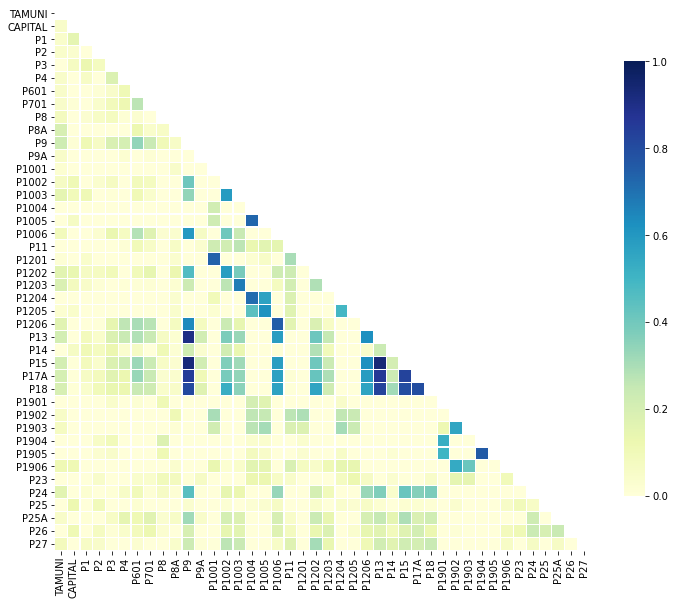

In [100]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

Como estamos ante un problema de clasificación, debemos transformar la variable objetivo, si tiene carácter numérico, en entero.

In [101]:
df_train['P9'] = df_train['P9'].astype('int64')

Definimos las matrices X e y del set de train, y con ello ya hemos terminado.

In [102]:
y_train = df_train['P9'].values

In [103]:
X_train = df_train.drop(['P9'], axis = 1).values

In [104]:
y_train.shape

(294,)

In [105]:
X_train.shape

(294, 41)

##Set de Test

Cargamos el set de test sin mayor novedad.

In [106]:
df_test = pd.read_csv('test_cis_malaga_modelo.txt')

In [107]:
df_test

,TAMUNI,CAPITAL,P1,P2,P3,P4,P601,P701,P8,P8A,...,P1903,P1904,P1905,P1906,P23,P24,P25,P25A,P26,P27
0,400.001 a 1.000.000 habitantes,Capital de provincia,Poco,Nunca o casi nunca,Muy mala,Mala,La falta de acuerdos. Situación política. Ines...,La educación,"Sí, con toda seguridad","Sí, lo tiene decidido",...,8,3,3,10,Mujer,55.0,"Sí, ha ido a la escuela","Bachillerato/COU/PREU (Bachillerato Superior, ...",Trabajo doméstico no remunerado,Católico/a no practicante
1,10.001 a 50.000 habitantes,Otros municipios,Nada,Rara vez,Muy mala,Mala,El paro,El paro,"No, con toda seguridad",NaN,...,5,5,5,5,Mujer,53.0,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Parado/a y ha trabajado antes,"Indiferente, no creyente"
2,2.001 a 10.000 habitantes,Otros municipios,Poco,De vez en cuando,Mala,Mala,El paro,El paro,"Sí, con toda seguridad","Sí, lo tiene decidido",...,6,1,1,8,Hombre,59.0,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Parado/a y ha trabajado antes,Católico/a no practicante
3,2.001 a 10.000 habitantes,Otros municipios,Nada,Rara vez,Mala,Muy mala,El paro,N.S.,Probablemente sí,"No, no lo ha decidido aún",...,5,5,5,5,Mujer,45.0,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Trabajo doméstico no remunerado,Católico/a no practicante
4,10.001 a 50.000 habitantes,Otros municipios,Bastante,De vez en cuando,Muy mala,Muy mala,El Gobierno y partidos o políticos/as concreto...,N.S.,"Sí, con toda seguridad","Sí, lo tiene decidido",...,6,1,1,8,Mujer,53.0,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Parado/a y ha trabajado antes,Católico/a no practicante
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,50.001 a 100.000 habitantes,Otros municipios,Poco,De vez en cuando,Mala,Mala,El paro,La falta de acuerdos. Situación política. Ines...,"Sí, con toda seguridad","Sí, lo tiene decidido",...,6,2,2,9,Mujer,57.0,"Sí, ha ido a la escuela",Formación Profesional de Grado Superior (FP II),Trabaja,Católico/a no practicante
70,10.001 a 50.000 habitantes,Otros municipios,Poco,Rara vez,Muy mala,Mala,"Los/as políticos/as en general, los partidos y...",N.S.,"Sí, con toda seguridad","Sí, lo tiene decidido",...,6,2,2,10,Mujer,31.0,"Sí, ha ido a la escuela","Secundaria (Bachillerato Elemental, EGB comple...",Trabaja,Católico/a no practicante
71,10.001 a 50.000 habitantes,Otros municipios,Poco,De vez en cuando,Muy mala,Mala,"Los/as políticos/as en general, los partidos y...",Los problemas de índole social,"Sí, con toda seguridad","Sí, lo tiene decidido",...,6,3,3,9,Mujer,42.0,"Sí, ha ido a la escuela",Formación Profesional de Grado Superior (FP II),Trabaja,Católico/a no practicante
72,400.001 a 1.000.000 habitantes,Capital de provincia,Nada,Nunca o casi nunca,Muy mala,Muy mala,La inmigración,Los problemas de índole económica,Probablemente sí,"Sí, lo tiene decidido",...,5,3,3,10,Mujer,63.0,"No, es analfabeto/a",NaN,Trabajo doméstico no remunerado,Católico/a no practicante


Naturalmente seguimos los mismos pasos que en el train, comenzando con el relleno de los nan de las columnas numéricas.

In [108]:
for item in FillNA_num_mean:
        
    df_test[item].fillna(df_test[item].mean(), inplace=True)

Aplicamos el mapeo definido en el set train.

In [109]:
for c in categorical:
    df_test[c] = df_test[c].map(mean_map1[c])

Ahora rellenamos los nan de las columnas que acabamos de mapear, igual que en el train.

In [110]:
for item in categorical:
        
    df_test[item].fillna(df_test[item].mean(), inplace=True)

In [111]:
df_test.dtypes

TAMUNI     float64
CAPITAL    float64
P1         float64
P2         float64
P3         float64
P4         float64
P601       float64
P701       float64
P8         float64
P8A        float64
P9         float64
P9A        float64
P1001        int64
P1002      float64
P1003        int64
P1004        int64
P1005      float64
P1006      float64
P11          int64
P1201        int64
P1202        int64
P1203        int64
P1204        int64
P1205        int64
P1206        int64
P13        float64
P14          int64
P15        float64
P17A       float64
P18          int64
P1901        int64
P1902        int64
P1903        int64
P1904        int64
P1905        int64
P1906        int64
P23        float64
P24        float64
P25        float64
P25A       float64
P26        float64
P27        float64
dtype: object

In [112]:
df_test.describe()

,TAMUNI,CAPITAL,P1,P2,P3,P4,P601,P701,P8,P8A,...,P1903,P1904,P1905,P1906,P23,P24,P25,P25A,P26,P27
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,...,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,44.959880,44.980966,45.268079,45.151610,45.569219,45.578973,45.775516,43.520464,44.811252,43.654480,...,5.945946,2.229730,2.297297,8.540541,44.912835,46.410089,44.971754,45.489908,44.568004,45.649779
std,6.240269,0.314619,2.461718,1.846806,4.377762,3.255109,11.233142,5.414870,3.207786,1.903825,...,1.058454,1.429123,1.487203,1.753190,0.222105,12.629043,0.894650,7.874646,4.585021,6.730530
min,29.705882,44.484536,35.600000,42.345679,23.750000,42.304688,17.500000,30.000000,39.218750,39.230769,...,5.000000,1.000000,1.000000,5.000000,44.720280,7.500000,37.500000,17.500000,30.769231,18.333333
25%,44.484536,44.484536,44.675325,42.345679,44.846939,42.304688,42.014925,43.000000,44.829268,43.654480,...,5.000000,1.000000,1.000000,8.000000,44.720280,37.625000,45.018450,43.385827,42.109375,45.979899
50%,47.600000,45.177665,45.529412,45.726496,44.846939,43.974359,42.014925,44.338624,44.829268,44.668246,...,6.000000,2.000000,2.000000,9.000000,44.720280,45.916667,45.018450,43.385827,42.735849,45.979899
75%,49.710145,45.177665,46.745283,47.187500,49.087302,50.000000,47.906977,45.379747,44.829268,44.668246,...,7.000000,3.000000,3.000000,10.000000,45.165563,55.416667,45.018450,49.629630,49.609929,45.979899
max,49.710145,45.177665,46.745283,47.187500,49.087302,50.000000,100.000000,70.000000,50.000000,44.668246,...,8.000000,5.000000,5.000000,10.000000,45.165563,76.666667,45.526316,65.625000,49.609929,59.523810


Pasamos la columna objetivo a tipo entero. Definimos las matrices X e y de test.

In [113]:
df_test['P9'] = df_test['P9'].astype('int64')

In [114]:
y_test = df_test['P9'].values

In [115]:
X_test = df_test.drop(['P9'], axis = 1).values

In [116]:
y_test.shape

(74,)

In [117]:
X_test.shape

(74, 41)

Antes de pasar a modelar, pasamos a ver la importancia de las distintas columnas. Vemos que las más importantes son las de recuerdo de voto 17A, político que considera más cercano, 13, partido que desearía ver ganador, 15, o la autoubicación, P8, aparte de las probabilidades de votar a los partidos (120x).

In [118]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [119]:
columnas = df_train.drop(['P9'], axis = 1).columns

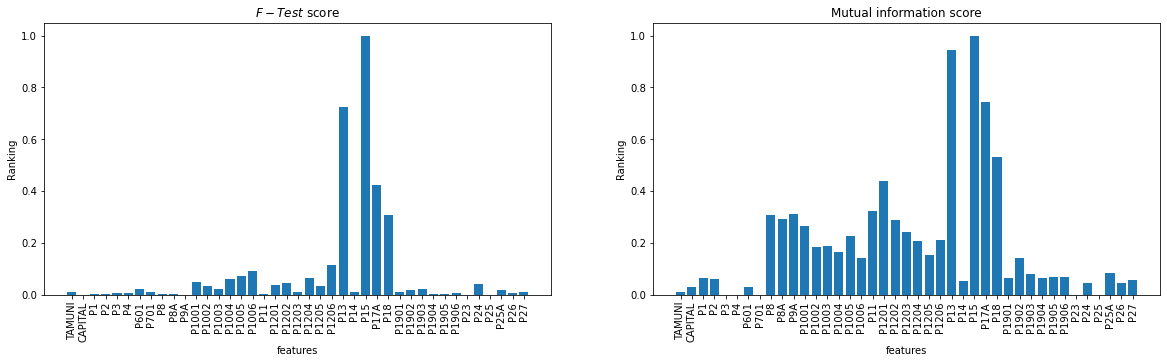

In [120]:
y = y_train    # nos quedamos con la 1ª columna, price
X = X_train      # nos quedamos con el resto

feature_names = columnas


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

Pasamos a modelizar. Instanciamos un modelo random forest classifier, utilizando GridSearch con la variable de la profundidad. El número de estimadores lo fijamos en 200, habitual para 40-45 columna.

## Modelización con Random Forest Classifier

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

best mean cross-validation score: 0.956
best parameters: {'max_depth': 8}


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


Text(0, 0.5, '10-fold ACC')

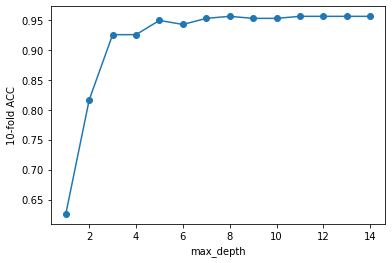

In [122]:
# grid search
maxDepth = range(1,15, 1)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt', verbose = 1), 
                    param_grid=tuned_parameters,cv=5) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

Vemos que conseguimos un accuracy de 0.95 con apenas una profundidad de 4. Para evitar overfitting nos quedamos con este hiperparámetro. Haciendo el fit obtenemos un accuracy muy satisfactorio, de más del 90% en test!!

In [123]:
# maxDepthOptimo = grid.best_params_['max_depth']
cis_malaga_model = RandomForestClassifier(max_depth = 4, n_estimators=200, max_features='sqrt').fit(X_train,y_train)

print("Train: ",cis_malaga_model.score(X_train,y_train))
print("Test: ",cis_malaga_model.score(X_test,y_test))

Train:  0.9659863945578231
Test:  0.9324324324324325


## Producción - Estimación de la intención de voto

Ahora debemos utilizar nuestro modelo en aquellos registros donde NO tenemos la intención de voto. que seleccionamos del dataset completo de Málaga a continuación.

In [124]:
cis_malaga_producccion = cis_malaga[cis_malaga['P9'].isna()]

In [125]:
cis_malaga_producccion

,TAMUNI,CAPITAL,P1,P2,P3,P4,P601,P701,P8,P8A,...,P1903,P1904,P1905,P1906,P23,P24,P25,P25A,P26,P27
9773,100.001 a 400.000 habitantes,Otros municipios,Poco,De vez en cuando,Regular,Buena,La corrupción y el fraude,Ninguno,"Sí, con toda seguridad","No, no lo ha decidido aún",...,5,2,2,8,Mujer,26,"Sí, ha ido a la escuela","Universitarios superiores (licenciatura, grado...",Trabaja,Agnóstico/a
9776,100.001 a 400.000 habitantes,Otros municipios,Bastante,De vez en cuando,Regular,Regular,La corrupción y el fraude,N.S.,"Sí, con toda seguridad","No, no lo ha decidido aún",...,7,2,2,9,Mujer,48,"Sí, ha ido a la escuela",Formación Profesional de Grado Superior (FP II),Trabaja,Católico/a no practicante
9788,10.001 a 50.000 habitantes,Otros municipios,Nada,De vez en cuando,Muy mala,Regular,La corrupción y el fraude,"Los/as políticos/as en general, los partidos y...","Sí, con toda seguridad","Sí, lo tiene decidido",...,5,3,2,9,Mujer,30,"Sí, ha ido a la escuela","Bachillerato/COU/PREU (Bachillerato Superior, ...",Trabaja,Católico/a no practicante
9794,10.001 a 50.000 habitantes,Otros municipios,Poco,Rara vez,Regular,Mala,La corrupción y el fraude,La educación,"Sí, con toda seguridad","No, no lo ha decidido aún",...,5,1,1,10,Hombre,21,"Sí, ha ido a la escuela","Bachillerato/COU/PREU (Bachillerato Superior, ...",Estudiante,Católico/a no practicante
9797,10.001 a 50.000 habitantes,Otros municipios,Bastante,Rara vez,Muy mala,Mala,El paro,Ninguno,Probablemente sí,"No, no lo ha decidido aún",...,7,2,2,10,Hombre,65,"Sí, ha ido a la escuela","Universitarios superiores (licenciatura, grado...",Jubilado/a o pensionista (anteriormente ha tra...,Católico/a no practicante
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10240,400.001 a 1.000.000 habitantes,Capital de provincia,Poco,De vez en cuando,Mala,Mala,El paro,Las pensiones,"Sí, con toda seguridad","No, no lo ha decidido aún",...,4,2,3,8,Mujer,82,"Sí, ha ido a la escuela",Primaria (enseñanza primaria o hasta 5º de EGB),Pensionista (anteriormente no ha trabajado),Católico/a no practicante
10241,400.001 a 1.000.000 habitantes,Capital de provincia,Poco,Habitualmente,Mala,Regular,La inseguridad ciudadana,Las pensiones,"Sí, con toda seguridad","No, no lo ha decidido aún",...,6,2,2,8,Hombre,64,"Sí, ha ido a la escuela","Bachillerato/COU/PREU (Bachillerato Superior, ...",Jubilado/a o pensionista (anteriormente ha tra...,Católico/a no practicante
10248,400.001 a 1.000.000 habitantes,Capital de provincia,Nada,De vez en cuando,Muy mala,Muy mala,Independencia de Cataluña,Los problemas relacionados con la calidad del ...,"Sí, con toda seguridad","No, no lo ha decidido aún",...,6,3,4,9,Mujer,57,"Sí, ha ido a la escuela",Primaria (enseñanza primaria o hasta 5º de EGB),Trabaja,Católico/a no practicante
10249,400.001 a 1.000.000 habitantes,Capital de provincia,Bastante,De vez en cuando,Muy mala,Muy mala,"Los/as políticos/as en general, los partidos y...",El paro,"Sí, con toda seguridad","Sí, lo tiene decidido",...,7,1,3,8,Hombre,40,"Sí, ha ido a la escuela","Universitarios superiores (licenciatura, grado...",Trabaja,Católico/a no practicante


Por supuesto, debemos preparar este dataset como hemos hecho con el train y test. Comenzamos por el relleno de los nan, no incluyendo desde luego la columna P9.

In [126]:
for item in FillNA_num_mean:
        
    cis_malaga_producccion[item].fillna(cis_malaga_producccion[item].mean(), inplace=True)

In [127]:
cis_malaga_producccion.describe()

,P9,P9A,P1001,P1002,P1003,P1004,P1005,P1006,P11,P1201,...,P14,P15,P17A,P18,P1901,P1902,P1903,P1904,P1905,P1906
count,0.0,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,...,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,NaN,47.566372,3.573913,3.086957,3.382609,2.704348,2.841121,2.228070,8.008696,3.026087,...,36.695652,47.920354,46.250000,4.747826,3.782609,7.452174,6.026087,2.321739,2.617391,8.634783
std,NaN,12.177687,2.263598,1.875817,2.253974,2.038979,1.960798,1.882678,2.783081,2.814315,...,11.079596,17.392851,17.977508,1.176103,1.106461,1.265213,1.012734,1.188747,1.203668,1.326719
min,NaN,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,30.000000,0.000000,0.000000,2.000000,1.000000,5.000000,4.000000,1.000000,1.000000,5.000000
25%,NaN,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,0.000000,...,30.000000,50.000000,30.000000,4.000000,3.000000,7.000000,5.000000,1.000000,2.000000,8.000000
50%,NaN,50.000000,3.000000,3.000000,3.000000,2.000000,2.841121,1.000000,9.000000,3.000000,...,30.000000,50.000000,46.250000,5.000000,4.000000,8.000000,6.000000,2.000000,3.000000,9.000000
75%,NaN,50.000000,5.000000,5.000000,5.000000,4.000000,4.000000,3.000000,10.000000,5.000000,...,50.000000,50.000000,60.000000,5.000000,5.000000,8.000000,7.000000,3.000000,3.000000,10.000000
max,NaN,65.000000,10.000000,7.000000,9.000000,10.000000,9.000000,10.000000,10.000000,10.000000,...,65.000000,100.000000,100.000000,9.000000,6.000000,10.000000,8.000000,5.000000,5.000000,10.000000


In [128]:
cis_malaga_producccion['P1'].value_counts()

Poco        47
Nada        30
Bastante    24
Mucho       14
N.C.         0
Name: P1, dtype: int64

In [129]:
mean_map1['P1']

P1
Bastante    44.675325
Mucho       35.600000
N.C.        60.000000
Nada        45.529412
Poco        46.745283
Name: P9, dtype: float64

In [130]:
cis_malaga_producccion['P1'].map(mean_map1['P1']).value_counts()

46.745283    47
45.529412    30
44.675325    24
35.600000    14
60.000000     0
Name: P1, dtype: int64

Pasamos a mapear las columnas categóricas con el mapeo del train. De nuevo, pasamos justo antes el tipo a object; sino nos encontramos con problemas.

In [131]:
for c in categorical:
    cis_malaga_producccion[c] = cis_malaga_producccion[c].astype('object').map(mean_map1[c])

In [132]:
cis_malaga_producccion.dtypes

TAMUNI     float64
CAPITAL    float64
P1         float64
P2         float64
P3         float64
P4         float64
P601       float64
P701       float64
P8         float64
P8A        float64
P9         float64
P9A        float64
P1001        int64
P1002      float64
P1003        int64
P1004        int64
P1005      float64
P1006      float64
P11          int64
P1201        int64
P1202        int64
P1203        int64
P1204        int64
P1205        int64
P1206        int64
P13        float64
P14          int64
P15        float64
P17A       float64
P18          int64
P1901        int64
P1902        int64
P1903        int64
P1904        int64
P1905        int64
P1906        int64
P23        float64
P24        float64
P25        float64
P25A       float64
P26        float64
P27        float64
dtype: object

Y finalmente nos encargamos de los nan de las columnas anteriormente categóricas.

In [133]:
for item in categorical:
        
    cis_malaga_producccion[item].fillna(cis_malaga_producccion[item].mean(), inplace=True)

In [134]:
cis_malaga_producccion.describe()

,TAMUNI,CAPITAL,P1,P2,P3,P4,P601,P701,P8,P8A,...,P1903,P1904,P1905,P1906,P23,P24,P25,P25A,P26,P27
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,...,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,45.457820,44.761788,44.639291,44.886417,45.228190,44.778569,45.818552,45.138145,44.120359,40.968520,...,6.026087,2.321739,2.617391,8.634783,44.925497,46.883319,45.036270,47.832229,45.656299,45.687311
std,3.789047,0.341048,3.474441,1.766618,4.524440,3.069546,9.604523,6.339404,2.530035,2.338902,...,1.012734,1.188747,1.203668,1.326719,0.222930,13.534387,0.093448,8.378328,5.230042,5.557660
min,29.705882,44.484536,35.600000,42.345679,23.750000,42.304688,17.500000,30.000000,39.218750,39.230769,...,4.000000,1.000000,1.000000,5.000000,44.720280,7.500000,45.018450,30.000000,25.000000,18.333333
25%,44.484536,44.484536,44.675325,42.345679,44.846939,42.304688,42.014925,43.409091,44.829268,39.230769,...,5.000000,1.000000,2.000000,8.000000,44.720280,39.444444,45.018450,43.385827,42.109375,45.979899
50%,44.484536,44.484536,45.529412,45.726496,44.846939,43.974359,42.014925,44.629630,44.829268,39.230769,...,6.000000,2.000000,3.000000,9.000000,44.720280,46.000000,45.018450,49.629630,49.609929,45.979899
75%,48.500000,45.177665,46.745283,45.726496,49.087302,44.347826,47.906977,45.379747,44.829268,44.668246,...,7.000000,3.000000,3.000000,10.000000,45.165563,56.666667,45.018450,53.088235,49.609929,45.979899
max,49.710145,45.177665,46.745283,47.187500,49.087302,50.000000,100.000000,70.000000,50.000000,44.668246,...,8.000000,5.000000,5.000000,10.000000,45.165563,76.666667,45.526316,65.625000,49.609929,59.523810


La matrix X, con la que haremos la predicción la definimos ahora quitando la columna P9, que es la que queremos predecir.

In [135]:
X_prod = cis_malaga_producccion.drop(['P9'], axis = 1).values

Y predecimos. Vemos que una gran cantidad de predicciones son 50, es decir, que estos encuestados finalmente no votarían.

In [136]:
y_prod = cis_malaga_model.predict(X_prod)

In [137]:
y_prod

array([ 50,  30,  50,  50,  50,  50,  60,  30,  50,  30,  50,  50,  50,
        50,  50,  50,  30,  50,  50,  50,  50,  50,  50,  50,  50,  50,
       100,  50,  50,  30,  30,  50,  50,  50,  50,  30,  70,  50,  50,
        50,  30,  50,  50,  60,  50,  50,  30,  50,  50,  50,  30,  30,
        30,  50,  50,   0,  50,  50,  50,   0,  50,  50,  50,  50,  50,
        50,  60,  50,  50,  50,  50,  50,  70,  50,  50,  50,  50,  50,
        50,  50,  30,  50,  50,  50,  50,  50,  30,  30,  30,  50,  30,
        50,  30,  60,  50,  50,  50,  30,  50,  50,  50,  50,  50,  50,
        50,  60, 100,   0,  50,  50,  30,  50,  50,  50,  50], dtype=int64)

## Estimación del voto de Málaga y comparación con el resultado real

Ahora rellenamos la columna P9 de este dataset, y la pasamos a enteros, aunque probablemente no hiciese falta.

In [138]:
cis_malaga_producccion['P9'] = y_prod

In [139]:
cis_malaga_producccion

,TAMUNI,CAPITAL,P1,P2,P3,P4,P601,P701,P8,P8A,...,P1903,P1904,P1905,P1906,P23,P24,P25,P25A,P26,P27
9773,47.600000,45.177665,46.745283,45.726496,39.435484,44.347826,40.365854,44.047619,44.829268,39.230769,...,5,2,2,8,44.720280,46.666667,45.01845,49.629630,49.609929,40.625000
9776,47.600000,45.177665,44.675325,45.726496,39.435484,42.304688,40.365854,34.666667,44.829268,39.230769,...,7,2,2,9,44.720280,53.333333,45.01845,65.625000,49.609929,45.979899
9788,48.500000,45.177665,45.529412,45.726496,49.087302,42.304688,40.365854,50.000000,44.829268,44.668246,...,5,3,2,9,44.720280,52.500000,45.01845,53.088235,49.609929,45.979899
9794,48.500000,45.177665,46.745283,42.345679,39.435484,43.974359,40.365854,41.250000,44.829268,39.230769,...,5,1,1,10,45.165563,15.000000,45.01845,53.088235,35.714286,45.979899
9797,48.500000,45.177665,44.675325,42.345679,49.087302,43.974359,42.014925,44.047619,39.218750,39.230769,...,7,2,2,10,45.165563,60.000000,45.01845,49.629630,42.109375,45.979899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10240,44.484536,44.484536,46.745283,45.726496,44.846939,43.974359,42.014925,44.629630,44.829268,39.230769,...,4,2,3,8,44.720280,23.750000,45.01845,35.200000,30.769231,45.979899
10241,44.484536,44.484536,46.745283,45.208333,44.846939,42.304688,80.000000,44.629630,44.829268,39.230769,...,6,2,2,8,45.165563,41.666667,45.01845,53.088235,42.109375,45.979899
10248,44.484536,44.484536,45.529412,45.726496,49.087302,50.000000,52.500000,40.535714,44.829268,39.230769,...,6,3,4,9,44.720280,43.750000,45.01845,35.200000,49.609929,45.979899
10249,44.484536,44.484536,44.675325,45.726496,49.087302,50.000000,47.906977,45.379747,44.829268,44.668246,...,7,1,3,8,45.165563,65.000000,45.01845,49.629630,49.609929,45.979899


In [140]:
cis_malaga_producccion['P9'] = cis_malaga_producccion['P9'].astype('int64')

In [141]:
cis_malaga_producccion

,TAMUNI,CAPITAL,P1,P2,P3,P4,P601,P701,P8,P8A,...,P1903,P1904,P1905,P1906,P23,P24,P25,P25A,P26,P27
9773,47.600000,45.177665,46.745283,45.726496,39.435484,44.347826,40.365854,44.047619,44.829268,39.230769,...,5,2,2,8,44.720280,46.666667,45.01845,49.629630,49.609929,40.625000
9776,47.600000,45.177665,44.675325,45.726496,39.435484,42.304688,40.365854,34.666667,44.829268,39.230769,...,7,2,2,9,44.720280,53.333333,45.01845,65.625000,49.609929,45.979899
9788,48.500000,45.177665,45.529412,45.726496,49.087302,42.304688,40.365854,50.000000,44.829268,44.668246,...,5,3,2,9,44.720280,52.500000,45.01845,53.088235,49.609929,45.979899
9794,48.500000,45.177665,46.745283,42.345679,39.435484,43.974359,40.365854,41.250000,44.829268,39.230769,...,5,1,1,10,45.165563,15.000000,45.01845,53.088235,35.714286,45.979899
9797,48.500000,45.177665,44.675325,42.345679,49.087302,43.974359,42.014925,44.047619,39.218750,39.230769,...,7,2,2,10,45.165563,60.000000,45.01845,49.629630,42.109375,45.979899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10240,44.484536,44.484536,46.745283,45.726496,44.846939,43.974359,42.014925,44.629630,44.829268,39.230769,...,4,2,3,8,44.720280,23.750000,45.01845,35.200000,30.769231,45.979899
10241,44.484536,44.484536,46.745283,45.208333,44.846939,42.304688,80.000000,44.629630,44.829268,39.230769,...,6,2,2,8,45.165563,41.666667,45.01845,53.088235,42.109375,45.979899
10248,44.484536,44.484536,45.529412,45.726496,49.087302,50.000000,52.500000,40.535714,44.829268,39.230769,...,6,3,4,9,44.720280,43.750000,45.01845,35.200000,49.609929,45.979899
10249,44.484536,44.484536,44.675325,45.726496,49.087302,50.000000,47.906977,45.379747,44.829268,44.668246,...,7,1,3,8,45.165563,65.000000,45.01845,49.629630,49.609929,45.979899


Ahora calcularemos nuestra predicción del resultado en Málaga. Comenzamos por crear un solo dataframe con los de train, test, y el predicho.

In [142]:
df = df_train.append(df_test).append(cis_malaga_producccion)

Nos quedamos solo con la columna de P9, y descartamos, para calcular porcentaje de voto, los registros de los encuestrados que no votan.

In [143]:
df_simp = df[['P9']]

In [144]:
df_simp = df_simp[df_simp['P9'] != 50]

In [145]:
df_simp

,P9
0,70
1,30
2,30
3,0
4,30
...,...
10209,30
10229,60
10230,100
10231,0


Para ganar en interpretabilidad, podemos deshacer el mapeo de los partidos, convirtiendo de nuevo los números en las siglas de estos. Calculamos los diccionarios inversos.

In [146]:
cod_partidos_P9 = {'Unidas Podemos' : 0,
                'Podemos' : 0,
                'IU' : 5, 
                'Más País' : 15,
                'PSOE' : 30,
                'Ciudadanos' : 60,
                'No votará' : 50,
                'PP' : 70,
                'VOX' : 100}

In [147]:
cod_partidos_P9_inv = dict([(value, key) for key, value in cod_partidos_P9.items()])

In [148]:
cod_partidos_P9_inv

{0: 'Podemos',
 5: 'IU',
 15: 'Más País',
 30: 'PSOE',
 60: 'Ciudadanos',
 50: 'No votará',
 70: 'PP',
 100: 'VOX'}

Vemos que la columna P9, el voto declarado y el predicho, indica un porcentaje de voto al PSOE del 45,9%.

In [149]:
df_simp['P9'] = df_simp['P9'].map(cod_partidos_P9_inv)

In [150]:
df_simp['P9'].value_counts() / df_simp['P9'].value_counts().sum()

PSOE          0.451807
PP            0.171687
Ciudadanos    0.126506
Podemos       0.111446
VOX           0.108434
IU            0.021084
Más País      0.009036
Name: P9, dtype: float64

Metemos estos datos en un dataframe, y para mayor comodidad, debido a nuestra ignorancia, reestablecemos el índice.

In [151]:
df_N19_est = pd.DataFrame(df_simp['P9'].value_counts() / df_simp['P9'].value_counts().sum())

In [152]:
df_N19_est

,P9
PSOE,0.451807
PP,0.171687
Ciudadanos,0.126506
Podemos,0.111446
VOX,0.108434
IU,0.021084
Más País,0.009036


In [153]:
df_N19_est = df_N19_est.reset_index()

In [154]:
df_N19_est

,index,P9
0,PSOE,0.451807
1,PP,0.171687
2,Ciudadanos,0.126506
3,Podemos,0.111446
4,VOX,0.108434
5,IU,0.021084
6,Más País,0.009036


Ahora es cuando ajustamos por el hecho de que hubiese votantes con intención de votar a IU, que no se presenta. Lo que hacemos es sumar ese porcentaje de voto a Unidas Podemos, y eliminamos a continuación la fila de IU.

In [155]:
df_N19_est['P9'][3] = df_N19_est['P9'][3] + df_N19_est['P9'][5]

In [156]:
df_N19_est

,index,P9
0,PSOE,0.451807
1,PP,0.171687
2,Ciudadanos,0.126506
3,Podemos,0.132530
4,VOX,0.108434
5,IU,0.021084
6,Más País,0.009036


In [157]:
df_N19_est = df_N19_est.loc[df_N19_est['index'] != 'IU']

In [158]:
df_N19_est

,index,P9
0,PSOE,0.451807
1,PP,0.171687
2,Ciudadanos,0.126506
3,Podemos,0.132530
4,VOX,0.108434
6,Más País,0.009036


Ahora tenemos que ver qué votaron los encuestados en las elecciones de abril, pregunta 17A, para poder apreciar el cambio de voto entre ambas elecciones. Procedemos a deshacer el mapeo, primero invirtiendo el diccionario utilizado.

In [159]:
cod_partidos = {'Unidas Podemos' : 0,
                'Podemos' : 0,
                'IU' : 5, 
                'Más País' : 15,
                'PSOE' : 30,
                'Ciudadanos' : 60,
                'Ninguno' : 50,
                'N.C.' : 50,
                'N.S.' : 50,
                'PP' : 65,
                'VOX' : 100,
                'Otro' : 50}

In [160]:
cod_partidos_inv = dict([(value, key) for key, value in cod_partidos.items()])

Tras una serie de operacines vemos que un 42% de encuestados votó al PSOE en abril del 19.

In [161]:
df_voto_decl_A19 = cis_malaga.loc[cis_malaga['P17A'].notna()]['P17A'].map(cod_partidos_inv).value_counts() / cis_malaga.loc[cis_malaga['P17A'].notna()]['P17A'].map(cod_partidos_inv).value_counts().sum()

In [162]:
df_voto_decl_A19

PSOE          0.422572
PP            0.170604
Ciudadanos    0.146982
Podemos       0.131234
VOX           0.081365
Otro          0.047244
Name: P17A, dtype: float64

Introducimos los datos en otro dataframe, y quitamos los 'otros'. Esto puede no ser muy ortodoxo, pero pensamos que favorece al menos la comparación.

In [163]:
df_A19_decl = pd.DataFrame(df_voto_decl_A19).reset_index()

In [164]:
df_A19_decl

,index,P17A
0,PSOE,0.422572
1,PP,0.170604
2,Ciudadanos,0.146982
3,Podemos,0.131234
4,VOX,0.081365
5,Otro,0.047244


In [165]:
df_A19_decl = df_A19_decl.loc[df_A19_decl['index'] != 'Otro']

In [166]:
df_A19_decl

,index,P17A
0,PSOE,0.422572
1,PP,0.170604
2,Ciudadanos,0.146982
3,Podemos,0.131234
4,VOX,0.081365


Ahora hacemos un merge con ambas df.

In [167]:
df = df_N19_est.merge(df_A19_decl, how = 'left', on = 'index')

In [168]:
df

,index,P9,P17A
0,PSOE,0.451807,0.422572
1,PP,0.171687,0.170604
2,Ciudadanos,0.126506,0.146982
3,Podemos,0.132530,0.131234
4,VOX,0.108434,0.081365
5,Más País,0.009036,NaN


Debemos partir del resultado real de las elecciones de abril en Málaga, que introducimos con los valores en orden.

In [169]:
df['Resultado_A19'] = [0.3084, 0.1771, 0.1951, 0.1449, 0.1399, 0]

In [170]:
df

,index,P9,P17A,Resultado_A19
0,PSOE,0.451807,0.422572,0.3084
1,PP,0.171687,0.170604,0.1771
2,Ciudadanos,0.126506,0.146982,0.1951
3,Podemos,0.132530,0.131234,0.1449
4,VOX,0.108434,0.081365,0.1399
5,Más País,0.009036,NaN,0.0000


Ahora hacemos la estimación, que es sumando al resultado de abril la variación entre lo que declaran los encuestados que votaron entonces, y lo que dicen, y estimamos, que harán en noviembre.

In [171]:
df['Resultado_estimado_N19'] =  df['Resultado_A19'] + df['P9'] - df['P17A'] 
df['Resultado_estimado_N19'][5] = df['P9'][5]

In [172]:
df

,index,P9,P17A,Resultado_A19,Resultado_estimado_N19
0,PSOE,0.451807,0.422572,0.3084,0.337635
1,PP,0.171687,0.170604,0.1771,0.178183
2,Ciudadanos,0.126506,0.146982,0.1951,0.174624
3,Podemos,0.132530,0.131234,0.1449,0.146197
4,VOX,0.108434,0.081365,0.1399,0.166969
5,Más País,0.009036,NaN,0.0000,0.009036


Introducimos ahora los resultados reales de noviembre.

In [173]:
df['Resultado_Real_N19'] = [0.3031, 0.218, 0.0895, 0.1307, 0.2168, 0.0189]

In [174]:
df

,index,P9,P17A,Resultado_A19,Resultado_estimado_N19,Resultado_Real_N19
0,PSOE,0.451807,0.422572,0.3084,0.337635,0.3031
1,PP,0.171687,0.170604,0.1771,0.178183,0.2180
2,Ciudadanos,0.126506,0.146982,0.1951,0.174624,0.0895
3,Podemos,0.132530,0.131234,0.1449,0.146197,0.1307
4,VOX,0.108434,0.081365,0.1399,0.166969,0.2168
5,Más País,0.009036,NaN,0.0000,0.009036,0.0189


In [175]:
df['Dif_Real-Estimado'] = df['Resultado_Real_N19'] - df['Resultado_estimado_N19']

Y nos encontrmos que, efectivamente, en línea con el sesgo del CIS a nivel nacional, el Centro sobrevaloró fuertemente al PSOE y especialmente a Cs, e infravaloró tanto al PP como claramente a Vox.

In [185]:
df

,index,Intencion_voto,Recuerdo_voto,Resultado_A19,Resultado_estimado_N19,Resultado_Real_N19,Dif_Real-Estimado
0,PSOE,0.451807,0.422572,0.3084,0.337635,0.3031,-0.034535
1,PP,0.171687,0.170604,0.1771,0.178183,0.2180,0.039817
2,Ciudadanos,0.126506,0.146982,0.1951,0.174624,0.0895,-0.085124
3,Podemos,0.132530,0.131234,0.1449,0.146197,0.1307,-0.015497
4,VOX,0.108434,0.081365,0.1399,0.166969,0.2168,0.049831
5,Más País,0.009036,NaN,0.0000,0.009036,0.0189,0.009864


In [180]:
df = df.rename(columns={'P9': 'Intencion_voto', 'P17A': 'Recuerdo_voto'})

In [206]:
df.to_csv('CISResult.csv', header= True)
df

,index,Intencion_voto,Recuerdo_voto,Resultado_A19,Resultado_estimado_N19,Resultado_Real_N19,Dif_Real-Estimado
0,PSOE,0.451807,0.422572,0.3084,0.337635,0.3031,-0.034535
1,PP,0.171687,0.170604,0.1771,0.178183,0.2180,0.039817
2,Ciudadanos,0.126506,0.146982,0.1951,0.174624,0.0895,-0.085124
3,Podemos,0.132530,0.131234,0.1449,0.146197,0.1307,-0.015497
4,VOX,0.108434,0.081365,0.1399,0.166969,0.2168,0.049831
5,Más País,0.009036,NaN,0.0000,0.009036,0.0189,0.009864


In [226]:
#para guardar el archivo en s3:

from botocore.exceptions import ClientError

s3_client = boto3.client(
    's3',
    aws_access_key_id='xxxxxxxx',
    aws_secret_access_key='xxxxxxxxxx',    
)

def upload_file(file_name, bucket, object_name=None):
    """Subir un archivo a un bucket
    :param file_name: archivo que hay que subir
    :param bucket: Bucket al que hay que subirlo
    :param object_name: S3 object name. Incluye la carpeta en la que hay que guardarlo. si no hay no se pone nada
    :return: True si sube el archivo, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    #s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [225]:
upload_file('CISResult.csv',
            'electomedia',
            object_name = "EstimacionOtrasFuentes/" + 'CISResult.csv'
           )

True